# NSL-KDD

### Library and dataset import

In [ ]:
from google.colab import drive
drive.mount('/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.utils import shuffle

import io
import requests
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# plot function
def plot_roc_curve(tpr, fpr, auc, atkClass, scatter = True, ax = None):
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, color = "red", ax = ax, label="Area under the Curve Score: %0.2f" % auc)
    sns.lineplot(x = [0, 1], y = [0, 1], color="purple", linestyle="--", ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [ ]:
#column name creation
columns = np.array(['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
           'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
           'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
           'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','Attack', 'difficulty'])
#features are data used by the algorithm
features = np.array(['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
           'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
           'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
           'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate'])
#target is the expected l'output
target = np.array(['Attack'])

In [ ]:
# dataset import
train = pd.read_csv('/drive/My Drive/GreenSoftware/Dataset/KDDTrain+.txt', names=columns)
test = pd.read_csv('/drive/My Drive/GreenSoftware/Dataset/KDDTest+.txt', names=columns)

### Preprocessing

In [ ]:
# deleting difficulty column (not necessary)
del train['difficulty']
del test['difficulty']

In [ ]:
#Load attacks.txt containing the attack categories
map_attacks = [x.strip().split() for x in open('/drive/My Drive/GreenSoftware/Dataset/attackMap.txt', 'r')]
map_attacks = {k:v for (k,v) in map_attacks}

train['Attack'] = train['Attack'].replace(map_attacks)
test['Attack'] = test['Attack'].replace(map_attacks)

In [ ]:
# joining train and test for encoding
df = pd.concat([train, test])

### AuC No Shuffle

#### Code

In [ ]:
accuracy = []
probability = []
falsePositive = []
truePositive = []
aucScore = []

In [ ]:
classes = ["normal", "dos", "probe", "r2l", "u2l"]

In [ ]:
for name in classes:
  copyDF = df.copy()
  attackStatus=[]
  for i in copyDF['Attack']:
      if i ==name:
          attackStatus.append(name)
      else:
         attackStatus.append("attack")           
  copyDF['Attack']=attackStatus

  #encoding object types
  for i in columns:
      if copyDF[i].dtypes==object:
          copyDF[i] = copyDF[i].astype('category')
          if i=="Attack":
              break
          copyDF=pd.get_dummies(copyDF, columns=[i])
  #feature e labels
  xCol = copyDF.columns.drop('Attack')
  x = copyDF[xCol].values
  dummies = pd.get_dummies(copyDF['Attack']) # Classification
  outcomes = dummies.columns
  num_classes = len(outcomes)
  y = dummies.values
  # normalization
  x = preprocessing.scale(x)
  x = preprocessing.normalize(x)
  X = x[:125973] # train+validation
  xTest = x[125973:] #  new data for evaluation
  Y = y[:125973] 
  yTest = y[125973:]
  xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size = 0.2, random_state = 42)
  #creazione modello
  model = Sequential()
  model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(50, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.add(Dense(yTrain.shape[1],activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                         patience=5, verbose=0, mode='auto',
                             restore_best_weights=True)
  #training
  print("Training: " + name)
  model.fit(xTrain,yTrain,validation_data=(xVal,yVal),
          callbacks=[monitor],verbose=0,epochs=1000)
  prediction = model.predict(xTest)
  probability.append(prediction)
  yPred = np.argmax(prediction,axis=1)
  yReal = np.argmax(yTest,axis=1)
  accuracy.append(metrics.accuracy_score(yReal, yPred))
  #AuC Score
  fp, tp, thresholds = roc_curve(yReal, yPred)
  falsePositive.append(fp)
  truePositive.append(tp)
  aucScore.append(auc(fp, tp))

Training: normal
Training: dos
Training: probe
Training: r2l
Training: u2l


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


#### Results

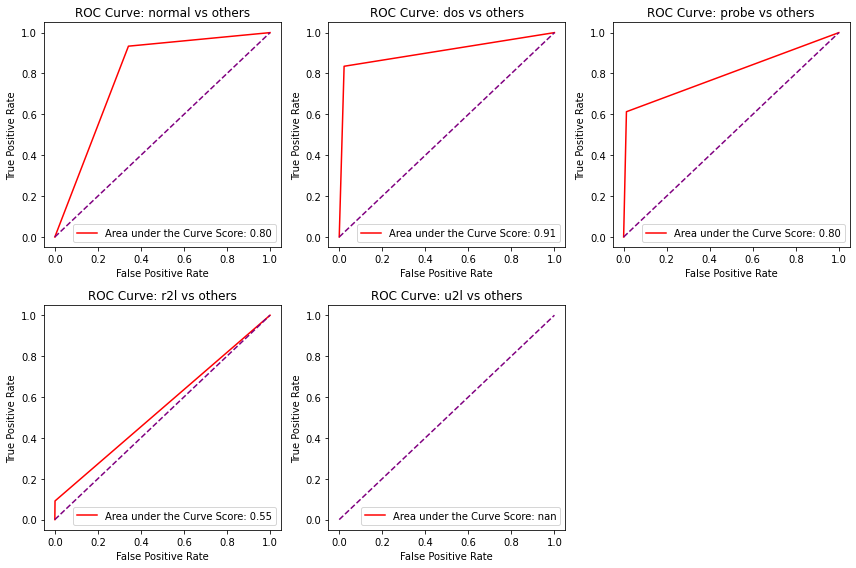

In [ ]:
# Plots ROC Curves One vs Rest
plt.figure(figsize = (12, 8))

for i in range(5):
    ax_bottom = plt.subplot(2, 3, i+1)
    plot_roc_curve(truePositive[i], falsePositive[i],aucScore[i], classes[i], scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve: " + classes[i] + " vs others")
    
plt.tight_layout()

In [ ]:
for i in range(5):
  print(classes[i])
  print("Validation score: {:.3f} ".format(accuracy[i]))
  print("True positives: {:.3f} " .format(truePositive[i][1]))
  print("False positives: {:.3f} " .format(falsePositive[i][1]))
  print("Area under the Curve score: {:.3f}" .format(aucScore[i]))
  print()

normal
Validation score: 0.777 
True positives: 0.934 
False positives: 0.342 
Area under the Curve score: 0.796

dos
Validation score: 0.930 
True positives: 0.835 
False positives: 0.023 
Area under the Curve score: 0.906

probe
Validation score: 0.947 
True positives: 0.613 
False positives: 0.013 
Area under the Curve score: 0.800

r2l
Validation score: 0.883 
True positives: 0.091 
False positives: 0.001 
Area under the Curve score: 0.545

u2l
Validation score: 1.000 
True positives: nan 
False positives: 1.000 
Area under the Curve score: nan



### AuC Shuffle

#### Code

In [ ]:
df = shuffle(df)

In [ ]:
accuracy1 = []
probability1 = []
falsePositive1 = []
truePositive1 = []
aucScore1 = []

In [ ]:
classes = ["normal", "dos", "probe", "r2l", "u2l"]

In [ ]:
for name in classes:
  copyDF = df.copy()
  attackStatus=[]
  for i in copyDF['Attack']:
      if i ==name:
          attackStatus.append(name)
      else:
         attackStatus.append("attack")           
  copyDF['Attack']=attackStatus

  #encoding object types
  for i in columns:
      if copyDF[i].dtypes==object:
          copyDF[i] = copyDF[i].astype('category')
          if i=="Attack":
              break
          copyDF=pd.get_dummies(copyDF, columns=[i])
  #feature e labels
  xCol = copyDF.columns.drop('Attack')
  x = copyDF[xCol].values
  dummies = pd.get_dummies(copyDF['Attack']) # Classification
  outcomes = dummies.columns
  num_classes = len(outcomes)
  y = dummies.values
  # normalization
  x = preprocessing.scale(x)
  x = preprocessing.normalize(x)
  X = x[:125973] # train+validation
  xTest = x[125973:] #  new data for evaluation
  Y = y[:125973] 
  yTest = y[125973:]
  xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size = 0.2, random_state = 42)
  #creazione modello
  model = Sequential()
  model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(50, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.add(Dense(yTrain.shape[1],activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                         patience=5, verbose=0, mode='auto',
                             restore_best_weights=True)
  #training
  print("Training: " + name)
  model.fit(xTrain,yTrain,validation_data=(xVal,yVal),
          callbacks=[monitor],verbose=0,epochs=1000)
  prediction = model.predict(xTest)
  probability1.append(prediction)
  yPred = np.argmax(prediction,axis=1)
  yReal = np.argmax(yTest,axis=1)
  accuracy1.append(metrics.accuracy_score(yReal, yPred))
  #AuC Score
  fp, tp, thresholds = roc_curve(yReal, yPred)
  falsePositive1.append(fp)
  truePositive1.append(tp)
  aucScore1.append(auc(fp, tp))

Training: normal
Training: dos
Training: probe
Training: u2l


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


#### Results

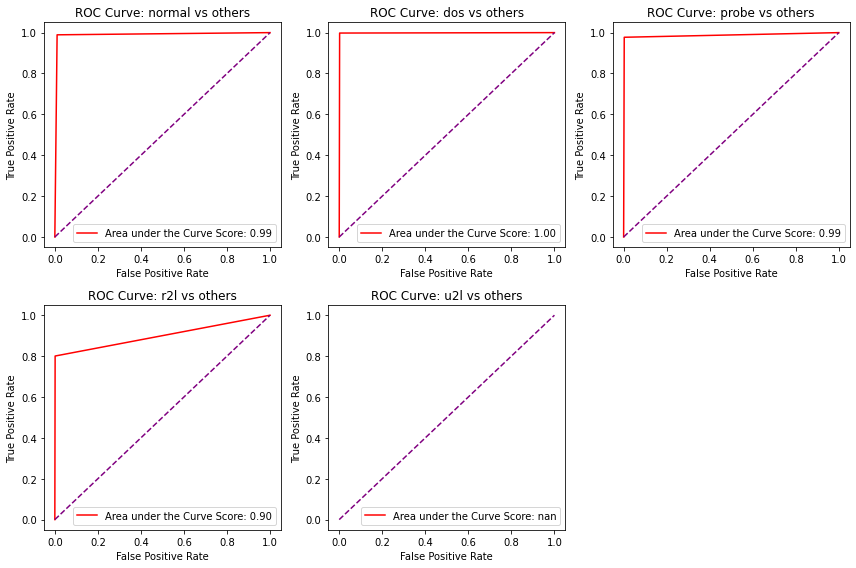

In [ ]:
# Plots ROC Curves One vs Rest
plt.figure(figsize = (12, 8))

for i in range(5):
    ax_bottom = plt.subplot(2, 3, i+1)
    plot_roc_curve(truePositive1[i], falsePositive1[i],aucScore1[i], classes[i], scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve: " + classes[i] + " vs others")
    
plt.tight_layout()

In [ ]:
for i in range(5):
  print(classes[i])
  print("Validation score: {:.3f} ".format(accuracy1[i]))
  print("True positives: {:.3f} " .format(truePositive1[i][1]))
  print("False positives: {:.3f} " .format(falsePositive1[i][1]))
  print("Area under the Curve score: {:.3f}" .format(aucScore1[i]))
  print()

normal
Validation score: 0.989 
True positives: 0.989 
False positives: 0.011 
Area under the Curve score: 0.989

dos
Validation score: 0.998 
True positives: 0.998 
False positives: 0.002 
Area under the Curve score: 0.998

probe
Validation score: 0.995 
True positives: 0.977 
False positives: 0.003 
Area under the Curve score: 0.987

r2l
Validation score: 0.993 
True positives: 0.800 
False positives: 0.001 
Area under the Curve score: 0.899

u2l
Validation score: 1.000 
True positives: nan 
False positives: 1.000 
Area under the Curve score: nan

